In [5]:
from ultralytics import YOLO
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import grid
from torchvision.transforms.functional import rgb_to_grayscale
import cv2
from skimage import measure 
import imutils 
import matplotlib.patches as patches
from IPython.display import Image
import torchvision 
import torch
from PIL import Image
import os
from torchvision.utils import make_grid


## Wstawić główna scieżke $\downarrow$

In [6]:
Parent_dir = "E:\\Projekt\\"
YoloPath = os.path.join(Parent_dir, "best.pt")
ImagePredPath = os.path.join(Parent_dir, "Test_image.jpg")

In [7]:
# Wczytanie modelu
model = YOLO(YoloPath)

In [8]:
device = torch.device("cuda:0")  # na pierwsze dostępne GPU
#device = torch.device("cpu")

model = model.to(device) 

In [9]:
test_result = model.predict(source=ImagePredPath,conf = 0.7)


image 1/1 E:\Projekt\Test_image.jpg: 640x480 1 license_plate, 53.9ms
Speed: 8.0ms preprocess, 53.9ms inference, 223.4ms postprocess per image at shape (1, 3, 640, 480)


In [10]:
img1 = test_result[0].plot()
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1 = Image.fromarray(img1)
img1 = img1.resize((400,400))

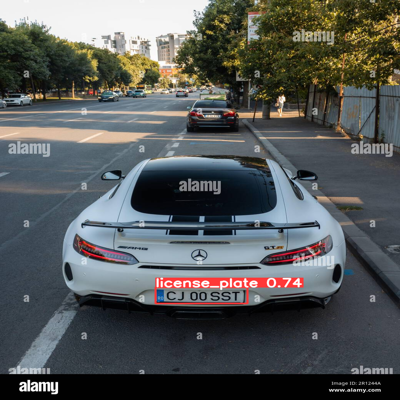

In [11]:
total_width = img1.width
max_height = img1.height
final_image = Image.new('RGB', (total_width, max_height))

# Paste resized images onto the final image
final_image.paste(img1, (0, 0))
display(final_image)

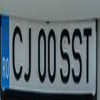

In [12]:
from PIL import Image
import cv2
from IPython.display import display

def get_cropped_boxes(result):
    img = result.orig_img  # Orginalne zdjęcie
    boxes = result.boxes.xyxy  # Obramowania

    cropped_boxes = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box[:4])
        cropped_img = img[y1:y2, x1:x2]  # Wykrojenie obrazu na podstawie obramowania
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        cropped_img = Image.fromarray(cropped_img)
        cropped_img = cropped_img.resize((100, 100))  # Zmiana rozmiaru
        cropped_boxes.append(cropped_img)

    return cropped_boxes

# Wykrojenie wszystkich obrazów
all_cropped_boxes = []
for result in test_result:
    cropped_boxes = get_cropped_boxes(result)
    all_cropped_boxes.extend(cropped_boxes)

# Wyświetlenie przykładu 
for box in all_cropped_boxes[:]:
    display(box)

In [13]:
from PIL import Image
import cv2
import os


def savecropped_boxes(result, output_dir, result_index):
    img = result.orig_img  # Oryginalne zdjęcie
    boxes = result.boxes.xyxy  # Obramowania

    # Utworzenie katalogu wyjściowego do zapisywania, jeśli nie istnieje
    os.makedirs(output_dir, exist_ok=True)

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box[:4])
        cropped_img = img[y1:y2, x1:x2]  # Wykrojenie obrazu na podstawie obramowania
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        cropped_img = Image.fromarray(cropped_img)
        cropped_img = cropped_img.resize((100, 100))  # Zmiana rozmiaru

        # Zapisanie obrazu do pliku 
        save_path = os.path.join(output_dir, f"cropped_box{result_index}{i}.jpg")
        cropped_img.save(save_path)


        print(f"Zapisano: {save_path}")
        return save_path


output_directory = Parent_dir # Katalog docelowy dla zapisanych obrazków

# Zapisanie wykrojonych obrazów
for idx, result in enumerate(test_result):
    path_temp = savecropped_boxes(result, output_directory, idx)

Zapisano: E:\Projekt\cropped_box00.jpg


In [14]:
Saved_img_path = os.path.split(path_temp)[1]

In [15]:
ii2 = cv2.imread(os.path.join(Parent_dir, Saved_img_path))

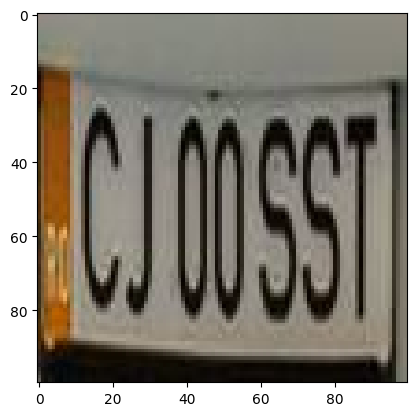

In [16]:
img2 = np.array(ii2)
plt.imshow(img2)

In [17]:
# Funkcja do wyszukiwania poszczególnych znaków na tablicy
def segment_chars(plate_img):

    V = cv2.split(cv2.cvtColor(plate_img, cv2.COLOR_BGR2HSV))[2] 
    thresh = cv2.adaptiveThreshold(V, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2) 

    thresh = cv2.bitwise_not(thresh) 
    labels = measure.label(thresh, background = 0) 
    charCandidates = np.zeros(thresh.shape, dtype ='uint8') 
    characters = [] 
    BoxXX = []
    BoxXY = []
    BoxXW = []
    BoxXH = []
    for label in np.unique(labels): 

        if label == 0: 

            continue
    
        labelMask = np.zeros(thresh.shape, dtype ='uint8') 
        labelMask[labels == label] = 255
        cnts = cv2.findContours(labelMask,  cv2.RETR_EXTERNAL,  cv2.CHAIN_APPROX_SIMPLE) 
        cnts = cnts[1] if imutils.is_cv3() else cnts[0] 
        if len(cnts) > 0: 
            c = max(cnts, key = cv2.contourArea) 
            (boxX, boxY, boxW, boxH) = cv2.boundingRect(c) 
        BoxXX.append(boxX)
        BoxXY.append(boxY)
        BoxXW.append(boxW)
        BoxXH.append(boxH)

    position = []      
    
    for contour in range(len(BoxXX)):
        if (BoxXW[contour]/float(BoxXH[contour])<1.0):
            if ((BoxXW[contour]<5) or (BoxXH[contour]> 95 or BoxXH[contour] < 30)):
                continue 
            else:
                position.append(contour)
                
    PositionX = [] 
    PositionY = []
    PositionW = []
    PositionH = []

    PositionXF = [] 
    PositionYF = []
    PositionWF = []
    PositionHF = []
    
    for i in position:
        PositionX.append(BoxXX[i])
        PositionY.append(BoxXY[i])
        PositionW.append(BoxXW[i])
        PositionH.append(BoxXH[i])

    
    indx = np.argsort(PositionX)
    for i in range(len(indx)):
        ind = np.argsort(PositionX)[i]
        PositionXF.append(PositionX[ind])
        PositionYF.append(PositionY[ind])
        PositionWF.append(PositionW[ind])
        PositionHF.append(PositionH[ind])

    if (len(PositionXF) == 0):
        print('Nie znaleziono znaków')

    
    return PositionXF,PositionYF,PositionWF,PositionHF


In [18]:
BoxXX,BoxXY,BoxXW,BoxXH = segment_chars(img2)

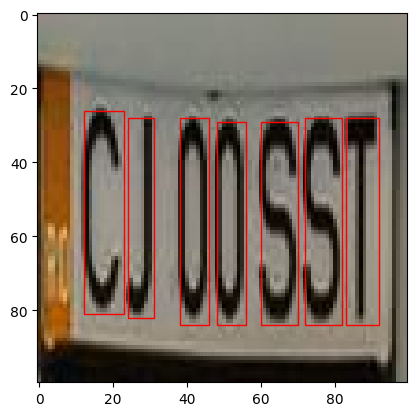

In [19]:
fig, ax = plt.subplots()

ax.imshow(img2)



for contour in range(len(BoxXX)):
    rect = patches.Rectangle((BoxXX[contour], BoxXY[contour]), BoxXW[contour], BoxXH[contour], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect) 

plt.show()

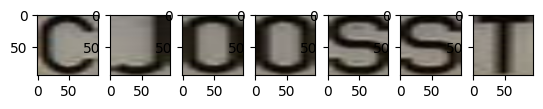

In [20]:
# Zmiana rozmiaru wyszukanych ramek ze znakami
f, axarr = plt.subplots(1,len(BoxXX)) 
for indeks in reversed(range(len(BoxXX))):
    axarr[indeks].imshow(cv2.resize(img2[BoxXY[indeks]:(BoxXY[indeks]+BoxXH[indeks]),BoxXX[indeks]:(BoxXX[indeks]+BoxXW[indeks]),:], (96,96)))


In [21]:
# Łączenie w jeden obraz
def box_to_image(img2,BoxXX, BoxXY, BoxXH, BoxXW):
    z = cv2.resize(img2[BoxXY[0]:(BoxXY[0]+BoxXH[0]),BoxXX[0]:(BoxXX[0]+BoxXW[0]),:], (96,96))
    for indeks in range(len(BoxXX)):
        i2 = cv2.resize(img2[BoxXY[indeks]:(BoxXY[indeks]+BoxXH[indeks]),BoxXX[indeks]:(BoxXX[indeks]+BoxXW[indeks]),:], (96,96))
        z = np.concatenate((z,i2),axis=1)
    return z[:,96:,:]

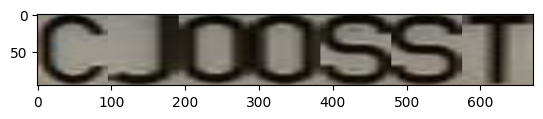

In [22]:
plt.imshow(box_to_image(img2, BoxXX, BoxXY, BoxXH, BoxXW))

In [23]:
z = box_to_image(img2, BoxXX, BoxXY, BoxXH, BoxXW)
im = Image.fromarray(z)
im.save(os.path.join(Parent_dir, 'segmented.jpg'))

In [24]:
model = torch.load(os.path.join(Parent_dir, 'model.pt'))
dir_path = os.path.join(Parent_dir, 'CNN_Letter')
digits = sorted(os.listdir(dir_path))

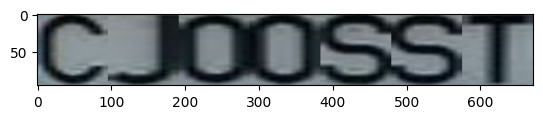

In [25]:
test2 = cv2.imread(os.path.join(Parent_dir,'segmented.jpg'))
plt.imshow(test2)


In [26]:
def listToString(s):
    str1 = ""
    for ele in s:
        str1 += ele
        
    return str1

In [27]:
def img_to_number(img):
    num_digits = img.shape[1]/96
    model.to("cpu")
    predictions = []
    for i in range(int(num_digits)):
        first_pxl = 96*i
        last_pxl = 96*i+96
        image = img[:,first_pxl:last_pxl,:]
        test_tensor = torch.from_numpy(image)
        test_tensor = test_tensor.permute(2,0,1)
        predictions.append(digits[torch.argmax(model(test_tensor.unsqueeze(0).float())[0,:]).item()])
    plt.imshow(img)
    plt.text(0,150, f'Predykcja: {listToString(predictions)}')
    return predictions

['C', 'J', '0', '0', 'S', 'S', 'T']


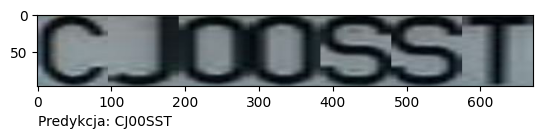

In [28]:
print(img_to_number(test2))